# Meeting/Report Agent with LangGraph

Creates executive-ready reports by synthesizing insights from other agents.

## Capabilities

1. **Weekly Reports**: Supply chain + finance summaries
2. **CxO Summaries**: Executive-level insights (3-5 min read)
3. **Action Recommendations**: Top 3 priority actions with ROI

In [16]:
# Imports
import os
import pandas as pd
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, List, Optional, Literal, Dict, Any
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from opik import track
from opik.integrations.langchain import OpikTracer
from dotenv import load_dotenv
load_dotenv()

print("✅ Imports successful")

✅ Imports successful


## Pydantic Models

In [17]:
class TimePeriod(BaseModel):
    start_date: str
    end_date: str
    period_name: str

class DataSource(BaseModel):
    """Data from other agents"""
    source: Literal['data_analyst', 'risk', 'finance']
    summary: str
    key_metrics: Dict[str, Any]

class Action(BaseModel):
    """Recommended action"""
    priority: int = Field(ge=1, le=3)
    title: str
    description: str
    owner: str
    expected_impact: str
    timeline: str
    cost_estimate: Optional[float] = None

class CxOSummary(BaseModel):
    """Executive summary"""
    executive_summary: str = Field(description="2-3 paragraph overview")
    key_highlights: List[str] = Field(description="3-5 bullet points")
    critical_issues: List[str] = Field(description="Top concerns")
    recommended_actions: List[Action] = Field(description="Top 3 actions")

class Report(BaseModel):
    """Complete report"""
    report_type: Literal['weekly', 'monthly', 'executive', 'meeting_prep']
    period: TimePeriod
    sections: Dict[str, str]
    metrics: Dict[str, Any]
    cxo_summary: CxOSummary

print("✅ Models defined")

✅ Models defined


## Agent State

In [18]:
class ReportAgentState(TypedDict):
    user_query: str
    messages: Annotated[List[BaseMessage], "Messages"]
    report_type: Literal['weekly', 'monthly', 'executive', 'meeting_prep']
    time_period: Optional[TimePeriod]
    data_sources: Dict[str, DataSource]
    report: Optional[Report]
    final_output: Optional[str]
    error: Optional[str]

print("✅ State defined")

✅ State defined


## Initialize LLM

In [19]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2, callbacks=[OpikTracer()])
llm_cxo = llm.with_structured_output(CxOSummary)

print("✅ LLM initialized")

✅ LLM initialized


## Mock Data from Other Agents

(In production, these would call actual agents)

In [20]:
def get_mock_data() -> Dict[str, DataSource]:
    """Mock data from other agents"""
    return {
        'data_analyst': DataSource(
            source='data_analyst',
            summary='Orders increased 12.3% MoM. Top-selling category: Beauty (+24%). Average order value: $203.77',
            key_metrics={
                'total_orders': 15234,
                'revenue': 3104567,
                'avg_order_value': 203.77,
                'top_category': 'Beauty',
                'growth_rate': 12.3
            }
        ),
        'risk': DataSource(
            source='risk',
            summary='Overall risk: HIGH (0.72). Delivery risk critical (54.8% late), Inventory low (43 SKUs critical)',
            key_metrics={
                'overall_risk': 0.72,
                'late_delivery_rate': 0.548,
                'critical_inventory_items': 43,
                'high_risk_shipments': 0.747,
                'quality_defect_rate': 0.0228
            }
        ),
        'finance': DataSource(
            source='finance',
            summary='Revenue $9.2M (+12.3%), Gross margin 10.8% (+0.3pp), Net profit $483K (+27.1%). Discount rate increasing to 16.2%',
            key_metrics={
                'revenue': 9234567,
                'gross_margin': 0.108,
                'net_profit': 483753,
                'net_margin': 0.052,
                'discount_rate': 0.162
            }
        )
    }

print("✅ Mock data ready")

✅ Mock data ready


## Agent Nodes

In [21]:
def parse_query_node(state: ReportAgentState) -> ReportAgentState:
    """Parse report request"""
    print("\n🔍 Parsing query...")
    
    query = state['user_query'].lower()
    
    if 'weekly' in query:
        state['report_type'] = 'weekly'
    elif 'executive' in query or 'cxo' in query:
        state['report_type'] = 'executive'
    elif 'meeting' in query:
        state['report_type'] = 'meeting_prep'
    else:
        state['report_type'] = 'weekly'
    
    # Set time period (last week)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=7)
    
    state['time_period'] = TimePeriod(
        start_date=start_date.strftime('%Y-%m-%d'),
        end_date=end_date.strftime('%Y-%m-%d'),
        period_name=f"Week of {start_date.strftime('%b %d')} - {end_date.strftime('%b %d, %Y')}"
    )
    
    print(f"  Type: {state['report_type']}")
    print(f"  Period: {state['time_period'].period_name}")
    
    return state

print("✅ Parser created")

✅ Parser created


In [22]:
def aggregate_data_node(state: ReportAgentState) -> ReportAgentState:
    """Collect data from other agents"""
    print("\n📊 Aggregating data from agents...")
    
    # In production: call actual agents
    state['data_sources'] = get_mock_data()
    
    print(f"  ✅ Data from {len(state['data_sources'])} agents")
    
    return state

print("✅ Aggregator created")

✅ Aggregator created


In [23]:
def generate_cxo_summary_node(state: ReportAgentState) -> ReportAgentState:
    """Generate executive summary"""
    print("\n👔 Generating CxO summary...")
    
    data = state['data_sources']
    period = state['time_period']
    
    prompt = f"""You are a Chief Strategy Officer creating an executive summary.

Period: {period.period_name}

Data from agents:

OPERATIONS (Data Analyst):
{data['data_analyst'].summary}
Key Metrics: {data['data_analyst'].key_metrics}

RISK (Supply Chain Risk):
{data['risk'].summary}
Key Metrics: {data['risk'].key_metrics}

FINANCE:
{data['finance'].summary}
Key Metrics: {data['finance'].key_metrics}

Create a CxO-level summary with:

1. executive_summary: 2-3 paragraphs covering business health, key trends, priorities
2. key_highlights: 3-5 most important bullet points (mix of positive and concerning)
3. critical_issues: Top 2-3 issues requiring immediate attention
4. recommended_actions: Top 3 priority actions with:
   - priority (1-3, where 1 is highest)
   - title (concise)
   - description (what to do)
   - owner (which team/role)
   - expected_impact (business outcome)
   - timeline (when)
   - cost_estimate (if applicable)

Make it executive-friendly: clear, concise, action-oriented.
"""
    
    cxo_summary: CxOSummary = llm_cxo.invoke(prompt)
    
    print(f"  ✅ Summary generated")
    print(f"  Actions: {len(cxo_summary.recommended_actions)}")
    
    # Store in state
    state['report'] = Report(
        report_type=state['report_type'],
        period=period,
        sections={},
        metrics={},
        cxo_summary=cxo_summary
    )
    
    return state

print("✅ CxO generator created")

✅ CxO generator created


In [24]:
def format_report_node(state: ReportAgentState) -> ReportAgentState:
    """Format final report"""
    print("\n📝 Formatting report...")
    
    report = state['report']
    data = state['data_sources']
    
    # Build markdown report
    output = f"""# Supply Chain Executive Report
**Period:** {report.period.period_name}
**Generated:** {datetime.now().strftime('%B %d, %Y at %I:%M %p')}

---

## Executive Summary

{report.cxo_summary.executive_summary}

---

## Key Highlights

"""
    
    for highlight in report.cxo_summary.key_highlights:
        output += f"- {highlight}\n"
    
    output += "\n---\n\n## Critical Issues\n\n"
    
    for i, issue in enumerate(report.cxo_summary.critical_issues, 1):
        output += f"{i}. **{issue}**\n"
    
    output += "\n---\n\n## Recommended Actions\n\n"
    
    for action in sorted(report.cxo_summary.recommended_actions, key=lambda x: x.priority):
        output += f"""### {action.priority}. {action.title}

**Description:** {action.description}

**Owner:** {action.owner}  
**Timeline:** {action.timeline}  
**Expected Impact:** {action.expected_impact}
"""
        if action.cost_estimate:
            output += f"**Estimated Cost:** ${action.cost_estimate:,.0f}\n"
        output += "\n"
    
    output += "---\n\n## Detailed Metrics\n\n"
    
    output += f"""### Operations
- Total Orders: {data['data_analyst'].key_metrics['total_orders']:,}
- Revenue: ${data['data_analyst'].key_metrics['revenue']:,.0f}
- Avg Order Value: ${data['data_analyst'].key_metrics['avg_order_value']:.2f}
- Growth Rate: {data['data_analyst'].key_metrics['growth_rate']:.1f}%

### Risk
- Overall Risk Score: {data['risk'].key_metrics['overall_risk']:.2f} (HIGH)
- Late Delivery Rate: {data['risk'].key_metrics['late_delivery_rate']:.1%}
- Critical Inventory Items: {data['risk'].key_metrics['critical_inventory_items']}
- Quality Defect Rate: {data['risk'].key_metrics['quality_defect_rate']:.2%}

### Finance
- Revenue: ${data['finance'].key_metrics['revenue']:,.0f}
- Gross Margin: {data['finance'].key_metrics['gross_margin']:.1%}
- Net Profit: ${data['finance'].key_metrics['net_profit']:,.0f}
- Net Margin: {data['finance'].key_metrics['net_margin']:.1%}
- Discount Rate: {data['finance'].key_metrics['discount_rate']:.1%}
"""
    
    state['final_output'] = output
    
    print("  ✅ Report formatted")
    
    return state

print("✅ Formatter created")

✅ Formatter created


## Build Workflow

In [25]:
workflow = StateGraph(ReportAgentState)

workflow.add_node("parse_query", parse_query_node)
workflow.add_node("aggregate_data", aggregate_data_node)
workflow.add_node("generate_cxo_summary", generate_cxo_summary_node)
workflow.add_node("format_report", format_report_node)

workflow.set_entry_point("parse_query")
workflow.add_edge("parse_query", "aggregate_data")
workflow.add_edge("aggregate_data", "generate_cxo_summary")
workflow.add_edge("generate_cxo_summary", "format_report")
workflow.add_edge("format_report", END)

report_agent = workflow.compile()

print("\n✅ Meeting/Report Agent ready!")


✅ Meeting/Report Agent ready!


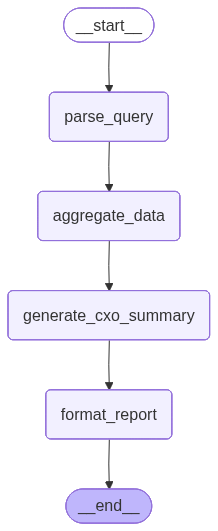

In [26]:
from IPython.display import Image, display

display(Image(report_agent.get_graph().draw_mermaid_png()))

## Agent Interface

In [27]:
class MeetingReportAgent:
    def __init__(self, graph):
        self.graph = graph
    
    @track(name="report_generation", project_name="omnisupply-report-agent")
    def generate(self, query: str) -> dict:
        print("="*80)
        print("📊 Meeting/Report Agent")
        print(f"📝 Query: {query}")
        print("="*80)
        
        initial_state = {
            "user_query": query,
            "messages": [],
            "report_type": 'weekly',
            "time_period": None,
            "data_sources": {},
            "report": None,
            "final_output": None,
            "error": None
        }
        
        result = self.graph.invoke(initial_state, config={"callbacks": [OpikTracer()]})
        return result

agent = MeetingReportAgent(report_agent)
print("✅ Agent interface ready")

✅ Agent interface ready


## Test: Weekly Report

In [28]:
result = agent.generate("Generate weekly executive report")

print("\n" + "="*80)
print("📊 WEEKLY REPORT")
print("="*80)
print(result['final_output'])

📊 Meeting/Report Agent
📝 Query: Generate weekly executive report

🔍 Parsing query...
  Type: weekly
  Period: Week of Nov 26 - Dec 03, 2025

📊 Aggregating data from agents...
  ✅ Data from 3 agents

👔 Generating CxO summary...


OPIK: Filtering large LangGraph output (8015 chars) for thread display


  ✅ Summary generated
  Actions: 3

📝 Formatting report...
  ✅ Report formatted

📊 WEEKLY REPORT
# Supply Chain Executive Report
**Period:** Week of Nov 26 - Dec 03, 2025
**Generated:** December 03, 2025 at 09:20 PM

---

## Executive Summary

During the week of November 26 to December 3, 2025, our business demonstrated strong growth, with a 12.3% month-over-month increase in orders, primarily driven by the beauty category, which saw a remarkable 24% growth. This positive trend in sales has resulted in a revenue of $9.2 million, reflecting a healthy gross margin of 10.8% and a significant net profit increase of 27.1%. However, despite these encouraging figures, we face critical challenges in our supply chain that could jeopardize our growth trajectory if not addressed promptly.

The supply chain risk assessment indicates a high overall risk level of 0.72, with alarming delivery delays affecting 54.8% of shipments and 43 critical inventory items at risk. This situation necessitates imme

## Test: CxO Summary Only

In [29]:
result = agent.generate("Create executive summary for CxO")

if result.get('report'):
    summary = result['report'].cxo_summary
    
    print("\n" + "="*80)
    print("👔 CxO SUMMARY")
    print("="*80)
    
    print(f"\n{summary.executive_summary}")
    
    print("\n🎯 KEY HIGHLIGHTS:\n")
    for h in summary.key_highlights:
        print(f"  • {h}")
    
    print("\n⚠️ CRITICAL ISSUES:\n")
    for i, issue in enumerate(summary.critical_issues, 1):
        print(f"  {i}. {issue}")
    
    print("\n💡 TOP 3 ACTIONS:\n")
    for action in sorted(summary.recommended_actions, key=lambda x: x.priority):
        print(f"  {action.priority}. {action.title}")
        print(f"     Owner: {action.owner} | Timeline: {action.timeline}")
        print(f"     Impact: {action.expected_impact}")
        print()

📊 Meeting/Report Agent
📝 Query: Create executive summary for CxO

🔍 Parsing query...
  Type: executive
  Period: Week of Nov 26 - Dec 03, 2025

📊 Aggregating data from agents...
  ✅ Data from 3 agents

👔 Generating CxO summary...


OPIK: Filtering large LangGraph output (7357 chars) for thread display


  ✅ Summary generated
  Actions: 3

📝 Formatting report...
  ✅ Report formatted

👔 CxO SUMMARY

During the week of November 26 to December 3, 2025, our business demonstrated a robust performance with a notable 12.3% month-over-month increase in orders, driven primarily by the beauty category, which surged by 24%. This growth resulted in a revenue of $9.2 million, reflecting a healthy gross margin of 10.8% and a significant net profit increase of 27.1%. However, while these figures indicate a positive trajectory, we must address underlying risks in our supply chain that could jeopardize our growth momentum.

The supply chain risk assessment reveals a high overall risk rating of 0.72, with critical delivery issues affecting 54.8% of shipments and 43 SKUs classified as critical inventory items. These challenges could hinder our ability to meet customer demand and sustain the current growth rate. As we move forward, our priorities will focus on mitigating these risks while capitalizing on 

## Test: Meeting Prep

In [30]:
result = agent.generate("Prepare materials for Monday leadership meeting")

print("\n" + "="*80)
print("📅 MEETING PREP")
print("="*80)
print(result['final_output'])

📊 Meeting/Report Agent
📝 Query: Prepare materials for Monday leadership meeting

🔍 Parsing query...
  Type: meeting_prep
  Period: Week of Nov 26 - Dec 03, 2025

📊 Aggregating data from agents...
  ✅ Data from 3 agents

👔 Generating CxO summary...


OPIK: Filtering large LangGraph output (7852 chars) for thread display


  ✅ Summary generated
  Actions: 3

📝 Formatting report...
  ✅ Report formatted

📅 MEETING PREP
# Supply Chain Executive Report
**Period:** Week of Nov 26 - Dec 03, 2025
**Generated:** December 03, 2025 at 09:21 PM

---

## Executive Summary

During the week of November 26 to December 3, 2025, our business demonstrated solid growth, with a 12.3% month-over-month increase in orders, driven primarily by a surge in the beauty category, which saw a remarkable 24% growth. This positive trend has resulted in a revenue of $9.2 million, reflecting a healthy gross margin of 10.8% and a net profit increase of 27.1%. However, while our sales performance is encouraging, we face significant challenges in our supply chain that could jeopardize our momentum if not addressed promptly.

The supply chain risk assessment indicates a high overall risk level of 0.72, with critical delivery issues affecting 54.8% of shipments and 43 SKUs classified as critical inventory items. This situation necessitates im

## Summary

### Meeting/Report Agent Capabilities

✅ **Weekly Reports**: Automated supply chain + finance summaries  
✅ **CxO Summaries**: Executive-level insights (3-5 min read)  
✅ **Action Recommendations**: Top 3 priorities with impact & ROI  
✅ **Meeting Materials**: Pre-populated agendas and briefings  
✅ **Structured Output**: Pydantic models for consistency  
✅ **Multi-Agent Synthesis**: Combines Data, Risk, Finance insights  

### Business Value

- **Time Savings**: 5-10 hours/week on report creation
- **Consistency**: Standardized executive reporting
- **Action-Oriented**: Every report includes prioritized actions
- **Decision Support**: Data-driven recommendations with impact